# GW AGN Example

In [1]:
from tqdm import tqdm
import numpy as np
from astropy.table import Table, vstack, hstack
from astropy.coordinates import SkyCoord
import astropy.units as u
import sys, os
sys.path.append('/mnt/rdliang/AGN/BBH_AGN/Cmash')
sys.path.append('/mnt/rdliang/AGN/BBH_AGN')
import Cmash
from astropy.time import Time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KernelDensity
import warnings
from ligo.skymap.io.fits import read_sky_map, write_sky_map
from ligo.skymap.postprocess import find_greedy_credible_levels
import healpy as hp
warnings.simplefilter("ignore")
plt.style.use('seaborn-v0_8-deep')

## O4a: Cross-match EP Known Source with AGN flare detected in Optical

In [6]:
EP_source_table

NameError: name 'EP_source_table' is not defined

In [7]:
agn_flare_table = Table.read('/mnt/rdliang/AGN/BBH_AGN/data/crossmatch/AGNflares_20250506.csv')
agn_flare_cat = SkyCoord(agn_flare_table['ra'],agn_flare_table['dec'],unit=u.deg)

EP_source_table = Table.read('/mnt/rdliang/AGN/BBH_AGN/data/all_source.csv')
EP_source_cat = SkyCoord(EP_source_table['RA'],EP_source_table['Dec'],unit=u.deg)

source_matched_idx, cat_matched_idx = Cmash.match_cat(agn_flare_cat,EP_source_cat,radius=3*u.arcmin)

agn_flare_matched, EP_source_matched = agn_flare_table[source_matched_idx], EP_source_table[cat_matched_idx]
matched_table = hstack((agn_flare_matched,EP_source_matched))
matched_table.write('/mnt/rdliang/AGN/BBH_AGN/data/AGNflare_EP_matched.csv',format='csv')

## EP Known Source Statistics

In [2]:
#Load Source List
wxt_known_source_cat = pd.read_csv('/mnt/rdliang/AGN/BBH_AGN/data/wxt_known_source_list.csv').rename(columns={'Source Name':'Common Name'})
transient_cat = pd.read_csv('/mnt/rdliang/AGN/BBH_AGN/data/transient_list.csv')
stellar_flare_cat = pd.read_csv('/mnt/rdliang/AGN/BBH_AGN/data/stellar_flare_list.csv')
all_source = wxt_known_source_cat.merge(transient_cat,how='outer')
all_source = all_source.merge(stellar_flare_cat,how='outer')

categories = np.unique(all_source['Category'].replace({np.nan:'Unclassified','X-ray Binary':'XRB','Unclassfied':'Unclassified'}))
property_flux = {cat:0 for cat in categories}

for cat in categories:
    print('%s : %s'%(cat,len(all_source[all_source['Category']==cat])))
    property_flux[cat] = all_source[all_source['Category']==cat]['Last Observed Flux'].to_numpy()

AGN : 1760
CV : 170
Cluster of Galaxies : 473
GRB : 26
Galaxy : 189
Nova : 5
Pulsar : 56
SNR : 71
Star : 2975
Star Cluster : 12
Supernovae : 2
TDE : 3
Unclassified : 508
Unverified : 7426
XRB : 439


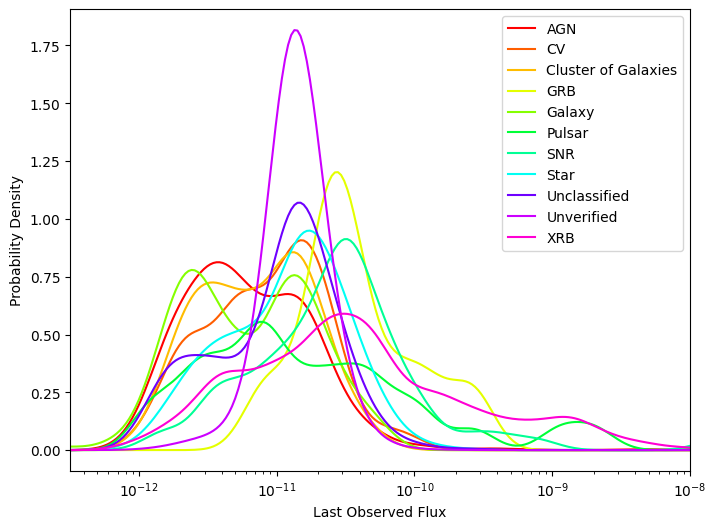

In [ ]:
#Flux histogram per category
cmap = plt.get_cmap('hsv', len(categories)+2)
cat_color = {cat:mpl.colors.rgb2hex(cmap(i)) for i,cat in enumerate(categories)}
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
bins = np.logspace(-12.5,-8,20)
x_plot = np.logspace(-12.5,-8,200)
for i,cat in enumerate(categories):
    data = property_flux[cat]
    if len(data) < 20:
        continue
    data = data[data != 0]
    data = np.log10(data).reshape(-1,1)
    #data[~np.isfinite(data)] = -10
    kde = KernelDensity(kernel='gaussian', bandwidth=0.15).fit(data)
    log_dens = kde.score_samples(np.log10(x_plot).reshape(-1,1))
    ax.plot(x_plot,np.exp(log_dens),color=cat_color[cat],label=cat)
    #ax.hist(property_flux[cat],bins=bins,histtype='step',color=cat_color[cat],density=True)
    #ax.hist(property_flux[cat],bins=bins,histtype='bar',color=cat_color[cat],alpha=0.3,density=True)
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(min(bins),max(bins))
ax.set_ylabel('Probability Density')
ax.set_xlabel('Last Observed Flux')
ax.legend()
#plt.savefig('/mnt/rdliang/AGN/BBH_AGN/figures/xflux_stat.png',dpi=300)

In [ ]:
#redshift distribution
from astroquery.simbad import Simbad
# 确保查询包含红移字段
Simbad.add_votable_fields('rvz_redshift')
#redshift in all_source.csv is the redshift in Simbad

all_source['redshift'] = np.empty(all_source.shape[0])
for i in tqdm(range(all_source.shape[0]),):
    name = all_source.loc[i,'Common Name']
    result = Simbad.query_object(name)
    if name is not None:
        try:
            redshift = result['rvz_redshift'][0]
            all_source.loc[i,'redshift'] = redshift
        except:
            #tqdm.write('No redshift information of %s on SIMBAD'%name)
            # print('No redshift information of %s on SIMBAD'%name,file=sys.stderr)
            all_source.loc[i,'redshift'] = None
all_source.to_csv('/mnt/rdliang/AGN/BBH_AGN/data/all_source.csv')

KeyboardInterrupt: 

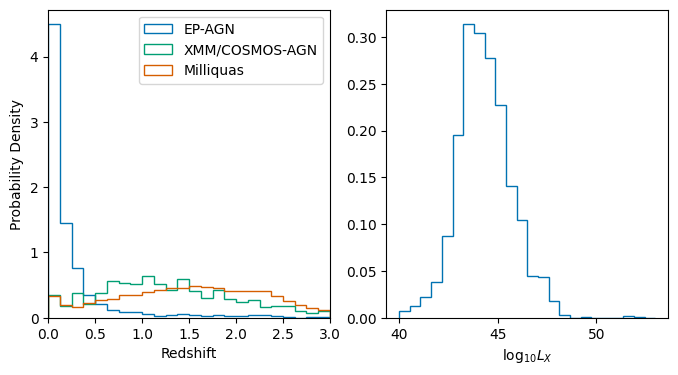

In [54]:
from astroquery.vizier import Vizier
from astropy.cosmology import Planck18

vizier = Vizier() # this instantiates Vizier with its default parameters
vizier.ROW_LIMIT = 1e3
xmm_agn = vizier.get_catalogs("J/ApJ/742/61/table5")
milliquas_cat = Table.read('/mnt/rdliang/AGN/BBH_AGN/data/Milliquas.csv',format='csv')
all_source = pd.read_csv('/mnt/rdliang/AGN/BBH_AGN/data/all_source.csv')


fig,ax = plt.subplots(1,2,figsize=(8,4))
plot_category = ['AGN']
bins = np.linspace(0,3,25)
bin_lum = np.linspace(40,53,25)
for cat in plot_category:
    ax[0].hist(all_source[all_source['Category']==cat]['redshift'],bins=bins,histtype='step',density=True,label='EP-'+cat)
ax[0].hist(xmm_agn[0]['zph'],bins=bins,histtype='step',density=True,label='XMM/COSMOS-AGN')
ax[0].hist(milliquas_cat['Z'][milliquas_cat['Z']<3],bins=bins,histtype='step',density=True,label='Milliquas')
ax[0].set_xlabel('Redshift')
ax[0].set_ylabel('Probability Density')
#ax.set_yscale('log')
ax[0].set_xlim(0,max(bins))
ax[0].legend()

ax[1].hist(np.log10(4*np.pi*all_source[all_source['Category']=='AGN']['Last Observed Flux']*Planck18.luminosity_distance(all_source[all_source['Category']=='AGN']['redshift']).to(u.cm).value**2),
           bins=bin_lum,histtype='step',density=True,label='EP-AGN')
ax[1].set_xlabel(r'$\mathrm{log_{10}}L_{X}$')
ax[1].set_xticks(np.arange(bin_lum[0],bin_lum[-1],5))
#plt.savefig('/mnt/rdliang/AGN/BBH_AGN/figures/AGN_z.png',dpi=300)

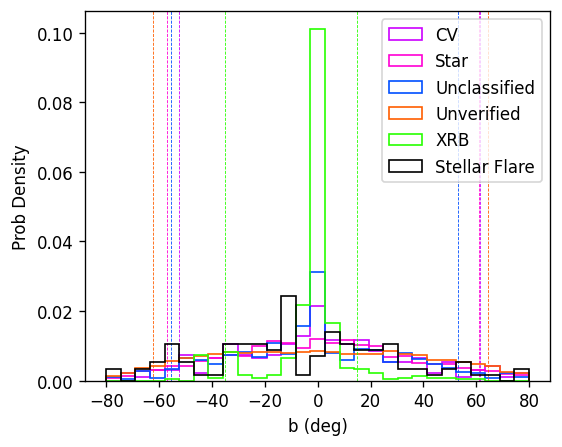

In [ ]:
fig, ax = plt.subplots(figsize=(5,4),dpi=120)
bins = np.linspace(-80,80,30)
cmap = plt.get_cmap('hsv', len(categories)+2)
cat_color = {cat:mpl.colors.rgb2hex(cmap(np.random.randint(0,len(categories)+2))) for i,cat in enumerate(categories)}
exGal = ['AGN','Cluster of Galaxies','Galaxy','Pulsar','SNR','GRB','Star Cluster','Nova','Supernovae','TDE']

for i,cat in enumerate(categories):
    if cat in exGal:
        continue
    c = SkyCoord(all_source[all_source['Category']==cat]['RA'],all_source[all_source['Category']==cat]['Dec'],unit=u.deg)
    b = c.galactic.b.deg
    Q5, Q95 = np.quantile(b,0.05), np.quantile(b,0.95)
    ax.hist(b,bins,histtype='step',color=cat_color[cat],label=cat,density=True)
    ax.axvline(Q5,0,1,color=cat_color[cat],ls='--',lw=0.5)
    ax.axvline(Q95,0,1,color=cat_color[cat],ls='--',lw=0.5)
    
c_sf = SkyCoord(all_source[all_source['Tags']=='["stellar_flare"]']['RA'],all_source[all_source['Tags']=='["stellar_flare"]']['Dec'],unit=u.deg)
b_sf = c_sf.galactic.b.deg
ax.hist(b_sf,histtype='step',bins=bins,density=True,color='k',label='Stellar Flare')
ax.set_xlabel('b (deg)')
ax.set_ylabel('Prob Density')
ax.legend(loc='upper right')
plt.savefig('/mnt/rdliang/AGN/BBH_AGN/figures/galsource_b.png',dpi=300)

## Known Source Data Clean

In [39]:
B_CONSTRAINT = 10

agn_table = Table.read('/mnt/rdliang/AGN/BBH_AGN/data/Milliquas.csv')
agn_cat = SkyCoord(agn_table['RA'],agn_table['DEC'],unit=u.deg)

EP_source_table = Table.read('/mnt/rdliang/AGN/BBH_AGN/data/all_source.csv')
EP_source_cat = SkyCoord(EP_source_table['RA'],EP_source_table['Dec'],unit=u.deg)

EP_source_table['b'] = EP_source_cat.galactic.b.deg
EP_source_table = EP_source_table[abs(EP_source_table['b'])>B_CONSTRAINT]
EP_source_cat = SkyCoord(EP_source_table['RA'],EP_source_table['Dec'],unit=u.deg)

source_matched_idx, cat_matched_idx, sep = Cmash.match_cat(agn_cat,EP_source_cat,radius=3*u.arcmin,seperation=True)

agn_matched, EP_source_matched = agn_table[source_matched_idx], EP_source_table[cat_matched_idx]
matched_table = hstack((agn_matched,EP_source_matched))
matched_table['sep(arcmin)'] = sep.arcmin
matched_table.write('/mnt/rdliang/AGN/BBH_AGN/data/AGN_EP_matched.csv',format='csv',overwrite=True)

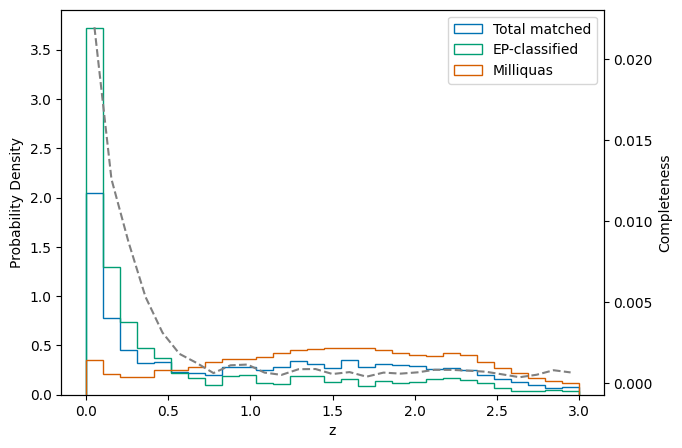

In [ ]:
matched_table = Table.read('/mnt/rdliang/AGN/BBH_AGN/data/AGN_EP_matched.csv',format='csv')
fig, ax = plt.subplots(figsize=(7,5),dpi=100)
bins = np.linspace(0,3,30)
ax.hist(matched_table['Z'],bins=bins,density=True,histtype='step',label='Total matched')
epagn_bins = ax.hist(matched_table[matched_table['Category']=='AGN']['Z'],bins=bins,density=True,histtype='step',label='EP-classified')
ax.hist(milliquas_cat['Z'][milliquas_cat['Z']<3],bins=bins,histtype='step',density=True,ls='--',label='Milliquas')

mili_hist, _ = np.histogram(milliquas_cat[milliquas_cat['Z']<3]['Z'],bins=bins)
epagn_hist, _ = np.histogram(matched_table[matched_table['Category']=='AGN']['Z'],bins=bins)
ax2 = ax.twinx()
ax2.plot(bins[:-1]+np.diff(bins)[0]/2,epagn_hist/mili_hist,ls='--',color='gray')
ax2.set_ylabel('Completeness')
ax.set_xlabel('z')
ax.set_ylabel('Probability Density')
ax.legend()
#plt.savefig('/mnt/rdliang/AGN/BBH_AGN/figures/EP_matched_AGN.png',dpi=300)

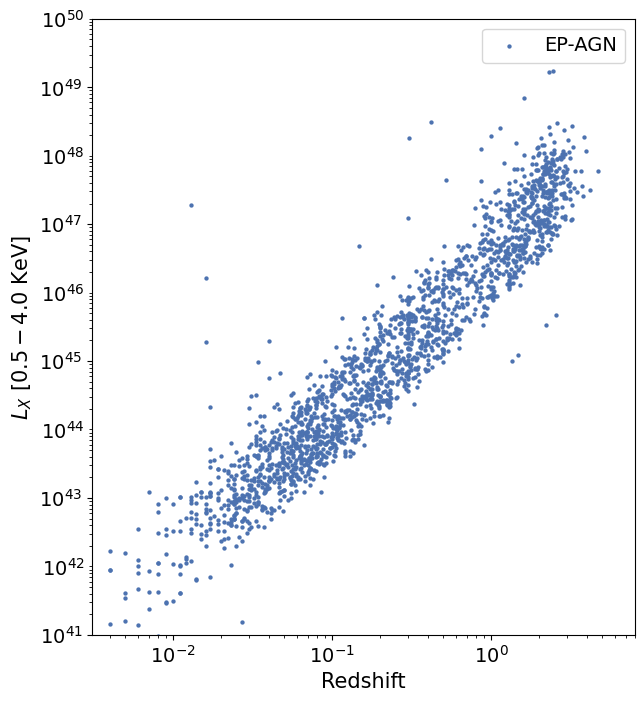

In [116]:
#AGN luminosity distribution
plt.style.use('seaborn-v0_8-deep')
from matplotlib.ticker import LogLocator, NullFormatter
fig, ax = plt.subplots(figsize=(7,8))
plt.rcParams["font.size"] = 14
bins = np.linspace(40,53,25)

EP_cl_AGN = matched_table[matched_table['Category']=='AGN']
LUM = EP_cl_AGN['Last Observed Flux']*4*np.pi*(Planck18.luminosity_distance(EP_cl_AGN['Z']).to(u.cm).value)**2
ax.scatter(EP_cl_AGN['Z'],LUM,s=4.5,label='EP-AGN')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Redshift',fontsize=15)
ax.set_ylabel(r'$L_{X}\ \mathrm{[0.5-4.0\ KeV]}$',fontsize=15)
ax.set_xlim([0.0031,8])
ax.set_ylim([1e41,1e50])
ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=20))
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs='all', numticks=12))
ax.legend()
plt.subplots_adjust()
#ax.tick_params(axis='both', which='both', length=3, color='gray')
plt.savefig('/mnt/rdliang/AGN/BBH_AGN/figures/EP_matched_AGN_LUMZ.png',dpi=300)

In [2]:
2400000.5 + 60437.250810

2460437.75081

In [35]:
print('Matched total: %s'%len(np.unique(matched_table['Source Name'])))
print('EP-AGN: %s'%len(EP_source_table[EP_source_table['Category']=='AGN']))
print('Matched EP-classified AGN: %s'%len(np.unique(matched_table[matched_table['Category']=='AGN']['Source Name'])))
print('Matched EP-unverified: %s'%len(np.unique(matched_table[matched_table['Category']=='Unverified']['Source Name'])))
print('Matched EP-unclassified: %s'%len(np.unique(matched_table[matched_table['Category']=='Unclassified']['Source Name'])))
print('======================================')

loop_cat = ['CV', 'Cluster of Galaxies', 'GRB', 'Galaxy', 'Nova',
       'Pulsar', 'SNR', 'Star', 'Star Cluster', 'Supernovae', 'TDE','XRB']
for cat in loop_cat:
    print('Matched EP-%s: %s'%(cat,len(np.unique(matched_table[matched_table['Category']==cat]['Source Name']))))

Matched total: 3039
EP-AGN: 1598
Matched EP-classified AGN: 1454
Matched EP-unverified: 1071
Matched EP-unclassified: 61
Matched EP-CV: 35
Matched EP-Cluster of Galaxies: 173
Matched EP-GRB: 0
Matched EP-Galaxy: 60
Matched EP-Nova: 0
Matched EP-Pulsar: 0
Matched EP-SNR: 0
Matched EP-Star: 166
Matched EP-Star Cluster: 1
Matched EP-Supernovae: 0
Matched EP-TDE: 0
Matched EP-XRB: 18


## Data-driven Source Detection

In [29]:
import requests
from bs4 import BeautifulSoup

def ra_dec_to_pix(ra,dec,nside):
    theta = 0.5 * np.pi - np.deg2rad(dec)
    phi = np.deg2rad(ra)
    return hp.ang2pix(nside, theta, phi)

def event_t0(event_id):
    'event_id[str]: ID should be conicide with IDs in GraceDb and return the trigger time in MJD'
    url = 'https://gracedb.ligo.org/superevents/{}/view/#event-information'.format(event_id)
    response = requests.get(url)
    soup = BeautifulSoup(response.text,'html.parser')
    html_str = str(soup.find_all('time')[1])
    soupt = BeautifulSoup(html_str,'html.parser')
    return Time(soupt.time['utc'][:-4],format='iso',scale='utc')

In [46]:
event_list = ['S240830gn','S240907cg','S240930aa','S241111bn','S241210d','S241231bg','S250208ad']
group_list = ['Bilby','Bilby','bayestar','Bilby.offline0','Bilby.offline0','Bilby','Bilby']
all_source = Table.read('/mnt/rdliang/AGN/BBH_AGN/data/all_source.csv',format='csv')
EP_AGN = all_source[all_source['Category']=='AGN']
EP_unverified = all_source[all_source['Category']=='unverified']
EP_AGN_c = SkyCoord(EP_AGN['RA'],EP_AGN['Dec'],unit=u.deg)


for event_name, group_name in zip(event_list,group_list):
    try:  #Read skymap
        skymap, meta = read_sky_map('https://gracedb.ligo.org/api/superevents/%s/files/%s.multiorder.fits'%(event_name,group_name),nest=False,distances=True)
    except:
        skymap, meta = read_sky_map('https://gracedb.ligo.org/api/superevents/%s/files/%s.fits.gz'%(event_name,group_name),nest=False,distances=True)
        
    EP_source_of_interest = Table.read('/mnt/rdliang/AGN/BBH_AGN/data/EP_AGN_GW/%s_source.csv'%event_name,format='csv')
    EP_source_of_interest = EP_source_of_interest[(EP_source_of_interest['Category']=='AGN') | (EP_source_of_interest['Category']=='Unverified')]
    t0 = event_t0(event_name)
    print('%s: %s'%(event_name,t0.iso))
    #calculate CL for AGN source and select CL < 0.9
    npix = len(skymap[0])
    nside = hp.npix2nside(npix)
    credible_levels = find_greedy_credible_levels(skymap[0])
    ipxs = ra_dec_to_pix(EP_source_of_interest['RA<br>(J2000)'],EP_source_of_interest['Dec<br>(J2000)'],nside)
    CLs = credible_levels[ipxs]
    EP_source_of_interest['CL'] = CLs
    EP_source_of_interest = EP_source_of_interest[EP_source_of_interest['CL']<0.9]
    EP_source_of_interest.pprint()
    EP_source_of_interest.write('/mnt/rdliang/AGN/BBH_AGN/data/EP_AGN_GW/%s_sourceinA90.csv'%event_name)
    # EP_AGN_GW.write('/mnt/rdliang/AGN/BBH_AGN/data/EP_AGN_GW/%s_%s.csv'%(event_name,t0.mjd),format='csv',overwrite=True)
    
    #Crossmatch with Catalogue
    # GW_AGN = Table.read('/mnt/rdliang/AGN/BBH_AGN/data/crossmatch/%s_AGN.csv'%event_name,format='csv')
    # GW_AGN_c = SkyCoord(GW_AGN['RA'],GW_AGN['DEC'],unit=u.deg)
    # source_matched_idx, cat_matched_idx, sep = Cmash.match_cat(EP_AGN_c,GW_AGN_c,radius=3*u.arcmin,seperation=True)
    # EP_AGN_GW_matched = EP_AGN[source_matched_idx]
    # GW_AGN_matched = GW_AGN[cat_matched_idx]
    # EP_AGN_GW_matched = hstack((EP_AGN_GW_matched,GW_AGN_matched))
    # EP_AGN_GW_matched['sep(arcmin)'] = sep.arcmin
    # EP_AGN_GW_matched.write('/mnt/rdliang/AGN/BBH_AGN/data/EP_AGN_GW/%s_matched_%s.csv'%(event_name,t0),format='csv',overwrite=True)
    

S240830gn: 2024-08-30 21:11:20.000
col0 Source ID Obs Time (UTC) RA<br>(J2000) ... AI_Prob Version  CL
---- --------- -------------- ------------- ... ------- ------- ---
S240907cg: 2024-09-07 15:38:33.000
col0 Source ID Obs Time (UTC) RA<br>(J2000) ... AI_Prob Version  CL
---- --------- -------------- ------------- ... ------- ------- ---
S240930aa: 2024-09-30 03:59:59.000
col0 Source ID Obs Time (UTC) RA<br>(J2000) ... AI_Prob Version  CL
---- --------- -------------- ------------- ... ------- ------- ---
S241111bn: 2024-11-11 11:15:52.000
col0      Source ID         Obs Time (UTC)   ... Version         CL        
---- ------------------- ------------------- ... ------- ------------------
  -- ep06800000223wxt9s1 2024-11-11 10:43:46 ...      v2 0.2926931841550741
S241210d: 2024-12-10 02:33:35.000
col0      Source ID          Obs Time (UTC)   ... Version          CL        
---- -------------------- ------------------- ... ------- -------------------
  -- ep11908921614wxt16s1 2024-12-

In [49]:
Time('2025-02-08 03:51:06.000').mjd

60714.16048611111